In [1]:
# import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#import sklearn
from scipy.optimize import minimize

Consider the following training data with two categories (labels):
$$C_1 : (1, 3)^T \quad (2, 3)^T \quad (2, 4)^T$$
$$C_{-1} : (3, 1)^T \quad (3, 2)^T \quad (4, 2)^T$$
That is, there are six training data points, each data point has two features and a corresponding
label.

Plot the data. 

Text(0.5, 1.0, 'Scatter-plot of the Data')

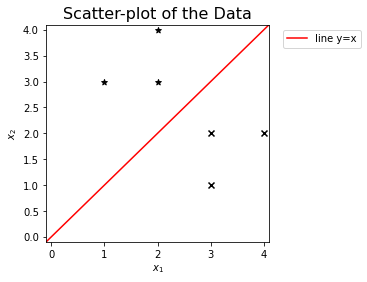

In [2]:
## plot the data with original line
C = np.array([[1,3,1],[2,3,1],[2,4,1],[3,1,-1],[3,2,-1],[4,2,-1]]) #one row of C is: x, y, label
label = C[:,2]

fig = plt.figure(figsize=(4,4))

plt.scatter(C[label==1,0],C[label==1,1],marker = "*",color = 'k')
plt.scatter(C[label==-1,0],C[label==-1,1],marker = "x",color ='k')

x = np.linspace(-0.1,4.1,100)
w = np.array([0,1,-1])
y = (-w[0] - w[1] * x)/w[2]
plt.plot(x, y, '-r', label='line y=x')
axes = plt.gca()
axes.set_ylim([-0.1,4.1])
axes.set_xlim([-0.1,4.1])
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
axes.set_xlabel('$x_1$')
axes.set_ylabel('$x_2$')
plt.title('Scatter-plot of the Data', fontsize = 16)

By visual inspection, the data reflects about the line $x_2 = x_1$ (i.e. this line separates the two classes of data). 
The line $x_2 = x_1$ is given by the equation for a hyperplane, $w^T x + b= 0$:
$$[-1,1] \begin{bmatrix}x_1 \\x_2 \end{bmatrix} +  0 = 0.$$

Let's now determine the optimal hyperplane for the SVM model. The two closest points to $x_2=x_1$ from opposite classes are $(2,3)^T$ and $(3,2)^T$. The line going through these two points will have a slope of $\frac{3-2}{2-3} = -1$. Since the optimal hyperplane for the SVM model will be orthogonal to the line with slope -1 then the optimal hyperplane has a slope of 1. The optimal hyperplane will also be equidistant to $(2,3)^T$ and $(3,2)^T$. Thus, we can confirm the line $x_2 = x_1$ is the optimal hyperplane for the SVM model.

Thus, weight vector $w = [-1,1]^T$ and bias $b = 0$ construct the optimal hyperplane $w^T x + b= 0$. 

Assuming we won't always be given such nice data, let's find the SVM model in a more rigorous way (i.e. not by visual inspection). 

Constructing the SVM model will require solving the corresponding quadratic programming problem in the dual Lagrangian formulation. Set our margin to be $m = \frac{2}{\|[-1,1]\|}$. We need to show $m$ is the solution to the optimization problem:
    $$
    \begin{aligned}
    & \underset{w}{\text{maximize}} & & \frac{2}{\|w\|} \\
    & \text{subject to}             & & y_i(w^T x(i) + b)\geq 1
    \end{aligned}
    $$
 which is equivalent to solving
    $$
    \begin{aligned}
    & \underset{w}{\text{minimize}} & & \|w\|\\
    & \text{subject to}             & & y_i(w^T x(i) + b)\geq 1
    \end{aligned}
    $$
and can be simplified to the Primal
    $$
    \begin{aligned}
    & \underset{w,b}{\text{minimize}} & & \frac{1}{2}w^T w \\
    & \text{subject to}             & & -y_i(w^T x(i) + b)+1\leq 0
    \end{aligned}\label{primal}
    $$
using the KKT conditions, we set $Q$ to be the outer product $Q = [y_1x_1,...,y_Nx_N]^T [y_1x_1,...,y_Nx_N]$ so the Dual becomes
    $$
    \begin{aligned}
    & \underset{\lambda}{\text{maximize}} & & \lambda^T 1- \frac{1}{2} \lambda^T Q \lambda\\
    & \text{subject to}             & & \lambda_i \geq 0 \\
    &                               & & \lambda^T y = 0 
    \end{aligned}\label{dual}
    $$
We use the quadratic programming solver $quadprog$, and recall that: $max~ f(x) = -min~-f(x)$ to encode it into the solver and find the optimal $\lambda$. 

In [3]:
# https://anaconda.org/omnia/quadprog
# https://scaron.info/blog/quadratic-programming-in-python.html
# troubleshooting: https://github.com/facebookresearch/GradientEpisodicMemory/issues/2
# troubleshooting: https://github.com/rmcgibbo/quadprog/blob/master/quadprog/quadprog.pyx
import quadprog

#converts standard form quadratic program into form quadprog will evaluate
# https://scaron.info/blog/quadratic-programming-in-python.html
def quadprog_solve_qp(P, q, G=None, h=None, A=None, b=None):
    qp_P = .5 * (P + P.T) + (1e-3)*np.eye(P.shape[0])  # make sure P is positive definite
    qp_q = -q
    if A is not None: #equality constraint present
        qp_C = -np.vstack([A, G]).T
        qp_b = np.reshape(-np.vstack([b, h]).T,(12))
        meq = int(A.shape[0]) # number of equality constraints
    else:  # no equality constraint present
        qp_C = -G.T
        qp_b = -h
        meq = 0
    return quadprog.solve_qp(qp_P, qp_q, qp_C, qp_b, meq)[0]

#the input matrix for SVM (in standard form)
Q = np.zeros([6,6])
for i in range(0,6):
    for j in range(0,6):
        Q[i,j] = (label[i] * label[j])*(C[i,0:2]@C[j,0:2])

#initialize variables to optimize over 
q = np.ones(6)
G = np.eye(6)
h = np.zeros([6,1])
A = np.zeros([6,6])
A[0,:] = label.T
b = np.zeros([6,1])

# solve the Dual using quadprog
L = np.round(quadprog_solve_qp(Q, q, G, h, A, b),2)
print("optimal lambda = ", -L)

# re-formulate L to solve the Primal
W = [-L[i] * label[i] * C[i,0:2] for i in range(6)]
w = np.array([sum(W[j][0] for j in range(6)), sum(W[j][1] for j in range(6))])

b = [(1 - label[k]*(w@C[k,0:2]))/(label[k]) for k in range(6)]
print("optimal w = ",w, ", optimal b = " , b)


optimal lambda =  [-0.  1. -0.  0.  1.  0.]
optimal w =  [-1.  1.] , optimal b =  [-1.0, 0.0, -1.0, 1.0, -0.0, 1.0]


We find the optimal solution to the Dual is
    $$
    \lambda^* = [0,1,0,0,1,0]. 
    $$
Now find the optimal solutions to the Primal, $w^*$ and $b^*$,
$$w^* = \sum_{i=1}^6 \lambda_i^* y_i x(i) = [-1,1]$$
$$b_i^* = \frac{1-y_i(w^*\cdot x(i))}{y_i}$$
$$b^* = [-1,0,-1,1,0,1]$$
Since we only consider the $b_i^*$ with $\lambda_i>0$, corresponding to active constraints in our dual, then our resulting optimal is 
$$b^* = 0.$$ 

Therefore, the optimal hyperplane is defined by vectors $w = [-1,1]^T$ and $b = [0,0]^T$, the same result as our visual inspection. 


Now, we compare the separating hyperplane in the SVM model with the Linear Discriminant Analysis (LDA) model. For the LDA we're looking for the plane 
$$w_0 + w^Tx = 0$$
such that the projection of the data onto the hyperplane $\hat{w}$ has maximum distribution between means, while minimizing the variance. We'll start by finding the distribution of the data in each one of the classes. \begin{align*}
   n_1 &= 3 & n_{-1} &= 3\\
   \mu_1 &= \left[\frac{5}{3}, \frac{10}{3}\right]^T & \mu_{-1} &= \left[\frac{10}{3}, \frac{5}{3}\right]^T\\
   \Sigma_1 &= \begin{bmatrix} \frac{2}{6} & \frac{1}{6} \\ \frac{1}{6} & \frac{2}{6} \end{bmatrix} & \Sigma_{-1} &= \begin{bmatrix} \frac{2}{6} & \frac{1}{6} \\ \frac{1}{6} & \frac{2}{6} \end{bmatrix}
\end{align*}
Using Fisher's optimility criteria, to maximize the differences in the mean and minimize the variance, we would like to find $w^*$ such that 
\begin{align*}
w^* &= \underset{w}{\text{argmax}} \frac{(w^T \mu_1 - w^T \mu_{-1})^2}{w^T\Sigma_1w + w^T \Sigma_{-1}w}\\
&= \underset{w}{\text{argmax}} \frac{(\left[-\frac{5}{3}, \frac{5}{3} \right] w)^2}{w^T \begin{bmatrix} \frac{2}{3} & \frac{1}{3} \\ \frac{1}{3} & \frac{2}{3} \end{bmatrix} w}
\end{align*}


In [5]:
# Class 1
n1 = 3
mu1 = np.average([C[i,0:2] for i in range(n1)],axis = 0)
cov1 = (1/(n1-1))*sum(np.outer((C[i,0:2]-mu1),(C[i,0:2]-mu1)) for i in range(n1))
# Class -1
n2 = 3
mu2 = np.average([C[i,0:2] for i in range(n1,n1+n2)],axis = 0)
cov2 = (1/(n2-1))*sum(np.outer((C[i,0:2]-mu2),(C[i,0:2]-mu2)) for i in range(n1,n1+n2))

# Returns the Cholesky decomposition 
# https://het.as.utexas.edu/HET/Software/Numpy/reference/generated/numpy.linalg.cholesky.html
R = np.transpose(np.linalg.cholesky(n1*cov1+n2*cov2))
#print(R)

w = np.linalg.inv(np.transpose(R)@R)@(mu1-mu2)
b = np.round((1/6)*sum((label[i] - w@C[i,0:2]) for i in range(n1+n2)),3)

print("optimal w =" ,w,'\n',"optimal b =",b)

optimal w = [-1.66666667  1.66666667] 
 optimal b = 0.0


Thus, the optimal solution occurs when 
$$
w^* = \frac{1}{c} \begin{bmatrix} \frac{2}{3} & \frac{1}{3} \\ \frac{1}{3} & \frac{2}{3} \end{bmatrix}^{-1}  \begin{bmatrix}-\frac{5}{3}\\ \frac{5}{3} \end{bmatrix}$$
where $c$ is an arbitrary constant,
\begin{align*}
&= \begin{bmatrix} \frac{2}{3} & -\frac{1}{3} \\ -\frac{1}{3} & \frac{2}{3} \end{bmatrix} \begin{bmatrix}-\frac{5}{3}\\ \frac{5}{3} \end{bmatrix}\\
&= \begin{bmatrix}-\frac{5}{3}\\ \frac{5}{3} \end{bmatrix}
\end{align*}
Now if $w_0^* = \frac{1}{6} \sum_{i=1}^6 y_i - w^* x(i)$, then $w_0^* = 0$. Thus the LDA optimal hyperplane is given by $w^* = \left[-\frac{5}{3}, \frac{5}{3}\right]^T$ and $w_0^*=[0,0]^T$. 


Observe that the hyperplane $w_0^* + w^{*T} x = 0$ is now the exact same hyperplane as the SVM and visual observation techniques. The only difference here is that our weight vector is $\left[-\frac{5}{3}, \frac{5}{3} \right]^T$, but this is just a constant multiple of $[-1,1]^T$, the weight predicted by the other techniques.